In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from tqdm import tqdm, trange

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor,Resize,Compose
from torchvision import datasets
from collections import Counter

from vit_overlap_random import ViT
from her2_dataset import HER2Dataset
from patch_embedding import PatchEmbedding

PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113


In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "C:/Users/Manel/Desktop/Practica2/git/CustomViT/plant-pathology-2020-fgvc7/images"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 100

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [3]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
N_PATCHES = 14
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop([IMAGE_WIDTH, IMAGE_HEIGHT]),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([IMAGE_WIDTH, IMAGE_HEIGHT]),
        transforms.CenterCrop([IMAGE_WIDTH, IMAGE_HEIGHT]),
        transforms.Resize([IMAGE_WIDTH, IMAGE_HEIGHT]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [4]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 2060 SUPER'

In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 2060 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
# Send the model to GPU
model_ft = ViT(
           in_channels= IMAGE_CHANNELS, 
           img_size=IMAGE_WIDTH,
           patch_size=IMAGE_WIDTH//N_PATCHES, 
           emb_size=768,
           num_heads=12,
           depth=12,
           n_classes=len(image_datasets['train'].classes), 
           dropout=0.1,
           forward_expansion=4,
           r=14*14
       ).to(device)

pytorch_total_params = sum(p.numel() for p in model_ft.parameters())
print(pytorch_total_params)

param_size = 0
for param in model_ft.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model_ft.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.2f}MB'.format(size_all_mb))

LR = 0.00001

85648130
model size: 326.72MB


Epoch 1 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:43<00:00,  1.35it/s]
                                                                                                                       

Epoch 1/100 loss: 0.65



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.65it/s]


Test loss: 0.57
Test accuracy: 71.35%
Model Saved!


Epoch 2 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.35it/s]
                                                                                                                       

Epoch 2/100 loss: 0.58



Training:   2%|█▍                                                                    | 2/100 [01:43<1:23:37, 51.20s/it]

Test loss: 0.60
Test accuracy: 71.17%



Epoch 3 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.33it/s]
                                                                                                                       

Epoch 3/100 loss: 0.58



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.51it/s]


Test loss: 0.54
Test accuracy: 73.54%
Model Saved!


Epoch 4 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 4/100 loss: 0.57



Training:   4%|██▊                                                                   | 4/100 [03:23<1:20:50, 50.52s/it]

Test loss: 0.56
Test accuracy: 72.63%



Epoch 5 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.34it/s]
                                                                                                                       

Epoch 5/100 loss: 0.56



Training:   5%|███▌                                                                  | 5/100 [04:13<1:19:33, 50.24s/it]

Test loss: 0.56
Test accuracy: 72.63%



Epoch 6 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.34it/s]
                                                                                                                       

Epoch 6/100 loss: 0.56



Training:   6%|████▏                                                                 | 6/100 [05:03<1:18:34, 50.15s/it]

Test loss: 0.55
Test accuracy: 71.72%



Epoch 7 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 7/100 loss: 0.56



Training:   7%|████▉                                                                 | 7/100 [05:53<1:17:37, 50.08s/it]

Test loss: 0.55
Test accuracy: 72.45%



Epoch 8 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.33it/s]
                                                                                                                       

Epoch 8/100 loss: 0.57



Training:   8%|█████▌                                                                | 8/100 [06:43<1:16:39, 49.99s/it]

Test loss: 0.57
Test accuracy: 72.08%



Epoch 9 in training: 100%|█████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 9/100 loss: 0.56



Training:   9%|██████▎                                                               | 9/100 [07:33<1:15:49, 50.00s/it]

Test loss: 0.56
Test accuracy: 73.72%



Epoch 10 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 10/100 loss: 0.55



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.54
Test accuracy: 72.08%
Model Saved!


Epoch 11 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 11/100 loss: 0.55



Training:  11%|███████▌                                                             | 11/100 [09:14<1:14:25, 50.17s/it]

Test loss: 0.54
Test accuracy: 73.36%



Epoch 12 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 12/100 loss: 0.55



Training:  12%|████████▎                                                            | 12/100 [10:04<1:13:40, 50.23s/it]

Test loss: 0.54
Test accuracy: 73.72%



Epoch 13 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 13/100 loss: 0.55



Training:  13%|████████▉                                                            | 13/100 [10:54<1:12:42, 50.14s/it]

Test loss: 0.55
Test accuracy: 75.73%



Epoch 14 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 14/100 loss: 0.55



Training:  14%|█████████▋                                                           | 14/100 [11:44<1:11:52, 50.15s/it]

Test loss: 0.54
Test accuracy: 73.54%



Epoch 15 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 15/100 loss: 0.55



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.52
Test accuracy: 73.91%
Model Saved!


Epoch 16 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 16/100 loss: 0.55



Training:  16%|███████████                                                          | 16/100 [13:25<1:10:24, 50.29s/it]

Test loss: 0.58
Test accuracy: 73.36%



Epoch 17 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 17/100 loss: 0.53



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.52
Test accuracy: 72.63%
Model Saved!


Epoch 18 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 18/100 loss: 0.53



Training:  18%|████████████▍                                                        | 18/100 [15:06<1:08:41, 50.26s/it]

Test loss: 0.55
Test accuracy: 75.00%



Epoch 19 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 19/100 loss: 0.52



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.51
Test accuracy: 75.36%
Model Saved!


Epoch 20 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 20/100 loss: 0.52



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.49
Test accuracy: 76.46%
Model Saved!


Epoch 21 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 21/100 loss: 0.51



Training:  21%|██████████████▍                                                      | 21/100 [17:37<1:06:16, 50.33s/it]

Test loss: 0.52
Test accuracy: 73.72%



Epoch 22 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 22/100 loss: 0.50



Training:  22%|███████████████▏                                                     | 22/100 [18:27<1:05:20, 50.26s/it]

Test loss: 0.51
Test accuracy: 78.10%



Epoch 23 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 23/100 loss: 0.57



Training:  23%|███████████████▊                                                     | 23/100 [19:17<1:04:25, 50.20s/it]

Test loss: 0.50
Test accuracy: 77.19%



Epoch 24 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 24/100 loss: 0.51



Training:  24%|████████████████▌                                                    | 24/100 [20:07<1:03:35, 50.20s/it]

Test loss: 0.51
Test accuracy: 77.74%



Epoch 25 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.32it/s]
                                                                                                                       

Epoch 25/100 loss: 0.49



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.56it/s]


Test loss: 0.47
Test accuracy: 78.28%
Model Saved!


Epoch 26 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 26/100 loss: 0.48



Training:  26%|█████████████████▉                                                   | 26/100 [21:48<1:01:54, 50.20s/it]

Test loss: 0.47
Test accuracy: 76.46%



Epoch 27 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 27/100 loss: 0.51



Training:  27%|██████████████████▋                                                  | 27/100 [22:38<1:00:59, 50.13s/it]

Test loss: 0.52
Test accuracy: 76.09%



Epoch 28 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 28/100 loss: 0.49



Training:  28%|███████████████████▎                                                 | 28/100 [23:28<1:00:08, 50.12s/it]

Test loss: 0.48
Test accuracy: 78.65%



Epoch 29 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 29/100 loss: 0.48



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.47
Test accuracy: 79.01%
Model Saved!


Epoch 30 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 30/100 loss: 0.47



Training:  30%|█████████████████████▎                                                 | 30/100 [25:09<58:38, 50.27s/it]

Test loss: 0.53
Test accuracy: 72.99%



Epoch 31 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 31/100 loss: 0.45



Training:  31%|██████████████████████                                                 | 31/100 [25:59<57:46, 50.25s/it]

Test loss: 0.47
Test accuracy: 78.28%



Epoch 32 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 32/100 loss: 0.47



Training:  32%|██████████████████████▋                                                | 32/100 [26:49<56:52, 50.18s/it]

Test loss: 0.48
Test accuracy: 76.28%



Epoch 33 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 33/100 loss: 0.47



Training:  33%|███████████████████████▍                                               | 33/100 [27:39<56:04, 50.21s/it]

Test loss: 0.48
Test accuracy: 78.10%



Epoch 34 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.30it/s]
                                                                                                                       

Epoch 34/100 loss: 0.46



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.52it/s]


Test loss: 0.46
Test accuracy: 77.55%
Model Saved!


Epoch 35 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 35/100 loss: 0.45



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.45
Test accuracy: 79.01%
Model Saved!


Epoch 36 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 36/100 loss: 0.47



Training:  36%|█████████████████████████▌                                             | 36/100 [30:11<53:45, 50.40s/it]

Test loss: 0.50
Test accuracy: 74.45%



Epoch 37 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 37/100 loss: 0.43



Training:  37%|██████████████████████████▎                                            | 37/100 [31:01<52:49, 50.31s/it]

Test loss: 0.46
Test accuracy: 80.11%



Epoch 38 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 38/100 loss: 0.42



Training:  38%|██████████████████████████▉                                            | 38/100 [31:51<51:55, 50.25s/it]

Test loss: 0.47
Test accuracy: 76.82%



Epoch 39 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 39/100 loss: 0.45



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]


Test loss: 0.42
Test accuracy: 79.56%
Model Saved!


Epoch 40 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 40/100 loss: 0.44



Training:  40%|████████████████████████████▍                                          | 40/100 [33:32<50:17, 50.29s/it]

Test loss: 0.47
Test accuracy: 77.92%



Epoch 41 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 41/100 loss: 0.43



Training:  41%|█████████████████████████████                                          | 41/100 [34:22<49:23, 50.23s/it]

Test loss: 0.47
Test accuracy: 78.83%



Epoch 42 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 42/100 loss: 0.42



Training:  42%|█████████████████████████████▊                                         | 42/100 [35:12<48:31, 50.20s/it]

Test loss: 0.44
Test accuracy: 79.74%



Epoch 43 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 43/100 loss: 0.41



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]


Test loss: 0.42
Test accuracy: 81.20%
Model Saved!


Epoch 44 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 44/100 loss: 0.41



Training:  44%|███████████████████████████████▏                                       | 44/100 [36:53<46:56, 50.29s/it]

Test loss: 0.42
Test accuracy: 80.66%



Epoch 45 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 45/100 loss: 0.40



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.40
Test accuracy: 81.02%
Model Saved!


Epoch 46 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 46/100 loss: 0.42



Training:  46%|████████████████████████████████▋                                      | 46/100 [38:34<45:24, 50.45s/it]

Test loss: 0.43
Test accuracy: 79.56%



Epoch 47 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 47/100 loss: 0.41



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.53it/s]


Test loss: 0.37
Test accuracy: 82.48%
Model Saved!


Epoch 48 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 48/100 loss: 0.39



Training:  48%|██████████████████████████████████                                     | 48/100 [40:15<43:40, 50.40s/it]

Test loss: 0.41
Test accuracy: 80.47%



Epoch 49 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 49/100 loss: 0.42



Training:  49%|██████████████████████████████████▊                                    | 49/100 [41:06<42:49, 50.38s/it]

Test loss: 0.40
Test accuracy: 80.66%



Epoch 50 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 50/100 loss: 0.41



Training:  50%|███████████████████████████████████▌                                   | 50/100 [41:56<41:57, 50.34s/it]

Test loss: 0.47
Test accuracy: 77.92%



Epoch 51 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 51/100 loss: 0.42



Training:  51%|████████████████████████████████████▏                                  | 51/100 [42:46<41:05, 50.32s/it]

Test loss: 0.41
Test accuracy: 80.29%



Epoch 52 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 52/100 loss: 0.39



Training:  52%|████████████████████████████████████▉                                  | 52/100 [43:36<40:12, 50.25s/it]

Test loss: 0.38
Test accuracy: 82.48%



Epoch 53 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 53/100 loss: 0.40



Training:  53%|█████████████████████████████████████▋                                 | 53/100 [44:26<39:21, 50.25s/it]

Test loss: 0.40
Test accuracy: 82.12%



Epoch 54 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 54/100 loss: 0.39



Training:  54%|██████████████████████████████████████▎                                | 54/100 [45:17<38:30, 50.22s/it]

Test loss: 0.44
Test accuracy: 79.56%



Epoch 55 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 55/100 loss: 0.37



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.56it/s]


Test loss: 0.37
Test accuracy: 82.66%
Model Saved!


Epoch 56 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 56/100 loss: 0.38



Training:  56%|███████████████████████████████████████▊                               | 56/100 [46:57<36:54, 50.32s/it]

Test loss: 0.41
Test accuracy: 81.57%



Epoch 57 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 57/100 loss: 0.36



Training:  57%|████████████████████████████████████████▍                              | 57/100 [47:48<36:03, 50.30s/it]

Test loss: 0.39
Test accuracy: 79.93%



Epoch 58 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 58/100 loss: 0.38



Training:  58%|█████████████████████████████████████████▏                             | 58/100 [48:38<35:10, 50.26s/it]

Test loss: 0.43
Test accuracy: 79.01%



Epoch 59 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 59/100 loss: 0.38



Training:  59%|█████████████████████████████████████████▉                             | 59/100 [49:28<34:19, 50.22s/it]

Test loss: 0.38
Test accuracy: 80.84%



Epoch 60 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 60/100 loss: 0.38



Training:  60%|██████████████████████████████████████████▌                            | 60/100 [50:18<33:25, 50.15s/it]

Test loss: 0.42
Test accuracy: 80.66%



Epoch 61 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 61/100 loss: 0.37



Training:  61%|███████████████████████████████████████████▎                           | 61/100 [51:08<32:33, 50.09s/it]

Test loss: 0.39
Test accuracy: 80.11%



Epoch 62 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 62/100 loss: 0.39



Training:  62%|████████████████████████████████████████████                           | 62/100 [51:58<31:43, 50.09s/it]

Test loss: 0.39
Test accuracy: 80.66%



Epoch 63 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 63/100 loss: 0.35



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.36
Test accuracy: 83.58%
Model Saved!


Epoch 64 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 64/100 loss: 0.37



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]


Test loss: 0.36
Test accuracy: 84.49%
Model Saved!


Epoch 65 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 65/100 loss: 0.35



Training:  65%|██████████████████████████████████████████████▏                        | 65/100 [54:30<29:23, 50.38s/it]

Test loss: 0.39
Test accuracy: 83.39%



Epoch 66 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 66/100 loss: 0.37



Training:  66%|██████████████████████████████████████████████▊                        | 66/100 [55:20<28:29, 50.27s/it]

Test loss: 0.41
Test accuracy: 82.30%



Epoch 67 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 67/100 loss: 0.36



Training:  67%|███████████████████████████████████████████████▌                       | 67/100 [56:10<27:38, 50.27s/it]

Test loss: 0.37
Test accuracy: 82.85%



Epoch 68 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 68/100 loss: 0.37



Training:  68%|████████████████████████████████████████████████▎                      | 68/100 [57:00<26:45, 50.16s/it]

Test loss: 0.39
Test accuracy: 81.57%



Epoch 69 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 69/100 loss: 0.35



Training:  69%|████████████████████████████████████████████████▉                      | 69/100 [57:50<25:56, 50.21s/it]

Test loss: 0.40
Test accuracy: 83.03%



Epoch 70 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 70/100 loss: 0.37



Training:  70%|█████████████████████████████████████████████████▋                     | 70/100 [58:41<25:06, 50.22s/it]

Test loss: 0.38
Test accuracy: 81.02%



Epoch 71 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 71/100 loss: 0.34



Training:  71%|██████████████████████████████████████████████████▍                    | 71/100 [59:31<24:15, 50.19s/it]

Test loss: 0.43
Test accuracy: 82.85%



Epoch 72 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 72/100 loss: 0.35



Training:  72%|█████████████████████████████████████████████████▋                   | 72/100 [1:00:21<23:27, 50.25s/it]

Test loss: 0.37
Test accuracy: 82.12%



Epoch 73 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 73/100 loss: 0.36



Training:  73%|██████████████████████████████████████████████████▎                  | 73/100 [1:01:11<22:34, 50.18s/it]

Test loss: 0.39
Test accuracy: 79.93%



Epoch 74 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 74/100 loss: 0.33



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]


Test loss: 0.35
Test accuracy: 82.48%
Model Saved!


Epoch 75 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 75/100 loss: 0.35



Training:  75%|███████████████████████████████████████████████████▊                 | 75/100 [1:02:52<20:56, 50.24s/it]

Test loss: 0.37
Test accuracy: 83.03%



Epoch 76 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 76/100 loss: 0.36



Training:  76%|████████████████████████████████████████████████████▍                | 76/100 [1:03:42<20:06, 50.29s/it]

Test loss: 0.37
Test accuracy: 82.12%



Epoch 77 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 77/100 loss: 0.34



Training:  77%|█████████████████████████████████████████████████████▏               | 77/100 [1:04:33<19:21, 50.51s/it]

Test loss: 0.38
Test accuracy: 83.94%



Epoch 78 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 78/100 loss: 0.34



Training:  78%|█████████████████████████████████████████████████████▊               | 78/100 [1:05:23<18:28, 50.37s/it]

Test loss: 0.37
Test accuracy: 82.30%



Epoch 79 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 79/100 loss: 0.36



Training:  79%|██████████████████████████████████████████████████████▌              | 79/100 [1:06:13<17:36, 50.31s/it]

Test loss: 0.40
Test accuracy: 80.47%



Epoch 80 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 80/100 loss: 0.33



Training:  80%|███████████████████████████████████████████████████████▏             | 80/100 [1:07:04<16:46, 50.30s/it]

Test loss: 0.36
Test accuracy: 83.94%



Epoch 81 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 81/100 loss: 0.33



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]


Test loss: 0.34
Test accuracy: 83.76%
Model Saved!


Epoch 82 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.33it/s]
                                                                                                                       

Epoch 82/100 loss: 0.35



Training:  82%|████████████████████████████████████████████████████████▌            | 82/100 [1:08:45<15:05, 50.32s/it]

Test loss: 0.40
Test accuracy: 81.39%



Epoch 83 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 83/100 loss: 0.30



Training:  83%|█████████████████████████████████████████████████████████▎           | 83/100 [1:09:35<14:14, 50.28s/it]

Test loss: 0.41
Test accuracy: 81.57%



Epoch 84 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.32it/s]
                                                                                                                       

Epoch 84/100 loss: 0.33



Training:  84%|█████████████████████████████████████████████████████████▉           | 84/100 [1:10:25<13:24, 50.31s/it]

Test loss: 0.40
Test accuracy: 81.20%



Epoch 85 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:39<00:00,  1.33it/s]
                                                                                                                       

Epoch 85/100 loss: 0.32



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.53it/s]


Test loss: 0.31
Test accuracy: 83.94%
Model Saved!


Epoch 86 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.29it/s]
                                                                                                                       

Epoch 86/100 loss: 0.33



Training:  86%|███████████████████████████████████████████████████████████▎         | 86/100 [1:12:07<11:49, 50.69s/it]

Test loss: 0.33
Test accuracy: 84.85%



Epoch 87 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 87/100 loss: 0.32



Training:  87%|████████████████████████████████████████████████████████████         | 87/100 [1:12:56<10:50, 50.01s/it]

Test loss: 0.38
Test accuracy: 81.57%



Epoch 88 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 88/100 loss: 0.32



Training:  88%|████████████████████████████████████████████████████████████▋        | 88/100 [1:13:44<09:54, 49.55s/it]

Test loss: 0.35
Test accuracy: 84.49%



Epoch 89 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 89/100 loss: 0.34



Training:  89%|█████████████████████████████████████████████████████████████▍       | 89/100 [1:14:33<09:01, 49.24s/it]

Test loss: 0.47
Test accuracy: 78.28%



Epoch 90 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 90/100 loss: 0.31



Training:  90%|██████████████████████████████████████████████████████████████       | 90/100 [1:15:21<08:10, 49.06s/it]

Test loss: 0.38
Test accuracy: 81.93%



Epoch 91 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 91/100 loss: 0.30



Training:  91%|██████████████████████████████████████████████████████████████▊      | 91/100 [1:16:10<07:20, 48.91s/it]

Test loss: 0.38
Test accuracy: 82.48%



Epoch 92 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 92/100 loss: 0.32



Training:  92%|███████████████████████████████████████████████████████████████▍     | 92/100 [1:16:58<06:29, 48.73s/it]

Test loss: 0.34
Test accuracy: 84.31%



Epoch 93 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 93/100 loss: 0.31



Training:  93%|████████████████████████████████████████████████████████████████▏    | 93/100 [1:17:47<05:40, 48.64s/it]

Test loss: 0.35
Test accuracy: 84.67%



Epoch 94 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 94/100 loss: 0.31



Training:  94%|████████████████████████████████████████████████████████████████▊    | 94/100 [1:18:35<04:51, 48.63s/it]

Test loss: 0.38
Test accuracy: 84.31%



Epoch 95 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 95/100 loss: 0.31



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.60it/s]


Test loss: 0.31
Test accuracy: 86.68%
Model Saved!


Epoch 96 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:36<00:00,  1.36it/s]
                                                                                                                       

Epoch 96/100 loss: 0.32



Training:  96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [1:20:13<03:14, 48.64s/it]

Test loss: 0.39
Test accuracy: 83.21%



Epoch 97 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 97/100 loss: 0.30



Testing: 100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.61it/s]


Test loss: 0.31
Test accuracy: 84.12%
Model Saved!


Epoch 98 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 98/100 loss: 0.31



Training:  98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [1:21:51<01:37, 48.74s/it]

Test loss: 0.34
Test accuracy: 83.39%



Epoch 99 in training: 100%|████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 99/100 loss: 0.29



Training:  99%|████████████████████████████████████████████████████████████████████▎| 99/100 [1:22:39<00:48, 48.67s/it]

Test loss: 0.34
Test accuracy: 82.85%



Epoch 100 in training: 100%|███████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.36it/s]
                                                                                                                       

Epoch 100/100 loss: 0.31



Training: 100%|████████████████████████████████████████████████████████████████████| 100/100 [1:23:28<00:00, 50.08s/it]


Test loss: 0.32
Test accuracy: 85.95%
86.67883211678831


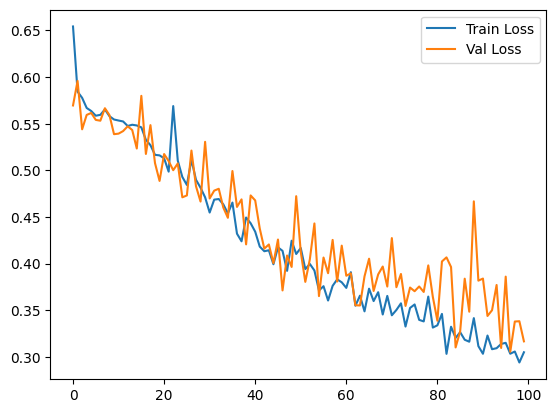

In [7]:
# Training loop
MODEL_PATH= "models/ViTOverlapplant2.pth"

optimizer_ft = Adam(model_ft.parameters(), lr=LR)
criterion = CrossEntropyLoss()
bestLoss = 999999;

train_losses = []
val_losses = []
test_accu = []
for epoch in trange(num_epochs, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(dataloaders_dict['train'], desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model_ft(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(dataloaders_dict['train'])

        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
    train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

# Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(dataloaders_dict['val'], desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model_ft(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(dataloaders_dict['val'])

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
        test_accu.append(correct / total * 100)
        val_losses.append(test_loss)
        if test_loss < bestLoss:
            print("Model Saved!")
            torch.save(model_ft.state_dict(), MODEL_PATH)
            bestLoss = test_loss


# %%
fig, ax = plt.subplots()

ax.plot(np.arange(num_epochs), train_losses)
ax.plot(np.arange(num_epochs), val_losses)
ax.legend(['Train Loss', 'Val Loss'])
print(max(test_accu))